In [1]:
UPDATE = "asynchronous"
DIRECTORY = "../models/random_nk3"
NUM_RUNS = 1
DEBUG = True
CUTOFF = 2

In [2]:
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg

from sdmarkov.transition_matrix import get_transition_matrix
from sdmarkov.graph import get_markov_chain
from sdmarkov.matrix_operations import compress_matrix
from sdmarkov.grouping import sd_grouping, null_grouping, random_grouping
from sdmarkov.paths import get_all_paths, get_all_shortest_paths, get_markov_chain_path_probs, get_stg_path_probs, get_random_path_probs
from sdmarkov.paths import compare_path_reachability, compare_path_rmsd

def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["paths_reachability"] = {}
    data["paths_rmsd"] = {}
    
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}
    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return data
    stg = primes2stg(percolated_primes, update)
    percolated_bnet = primes2bnet(percolated_primes)

    # Get the transition matrix
    T = get_transition_matrix(stg, DEBUG=DEBUG)

    # Get path probabilities for the sd grouped transition matrix
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)
    sd_markov_chain = get_markov_chain(Tsd, sd_indices, DEBUG=DEBUG)
    sd_all_paths = get_all_paths(sd_markov_chain, DEBUG=DEBUG)
    sd_markov_chain_path_probs = get_markov_chain_path_probs(sd_markov_chain, sd_all_paths, DEBUG=DEBUG)
    sd_stg_path_probs = get_stg_path_probs(sd_all_paths, sd_indices, stg, T, DEBUG=DEBUG)

    # Get comparison results
    data["paths_reachability"]["sd_all"] = compare_path_reachability(sd_stg_path_probs, sd_markov_chain_path_probs, type="all", DEBUG=DEBUG)
    data["paths_reachability"]["sd_edges"] = compare_path_reachability(sd_stg_path_probs, sd_markov_chain_path_probs, type="edges", DEBUG=DEBUG)
    data["paths_reachability"]["sd_non_edges"] = compare_path_reachability(sd_stg_path_probs, sd_markov_chain_path_probs, type="non_edges", DEBUG=DEBUG)

    data["paths_rmsd"]["sd_all"] = compare_path_rmsd(sd_stg_path_probs, sd_markov_chain_path_probs, type="all", DEBUG=DEBUG)
    data["paths_rmsd"]["sd_edges"] = compare_path_rmsd(sd_stg_path_probs, sd_markov_chain_path_probs, type="edges", DEBUG=DEBUG)
    data["paths_rmsd"]["sd_non_edges"] = compare_path_rmsd(sd_stg_path_probs, sd_markov_chain_path_probs, type="non_edges", DEBUG=DEBUG)

    # Get path rmsd for randomized markov chains
    data["paths_rmsd"]["sd_all_randomized"] = []
    data["paths_rmsd"]["sd_edges_randomized"] = []
    data["paths_rmsd"]["sd_non_edges_randomized"] = []

    for i in range(num_runs):
        random_path_probs = get_random_path_probs(sd_markov_chain_path_probs, seed=i)
        data["paths_rmsd"]["sd_all_randomized"].append(compare_path_rmsd(sd_stg_path_probs, random_path_probs, type="all", DEBUG=DEBUG))
        data["paths_rmsd"]["sd_edges_randomized"].append(compare_path_rmsd(sd_stg_path_probs, random_path_probs, type="edges", DEBUG=DEBUG))
        data["paths_rmsd"]["sd_non_edges_randomized"].append(compare_path_rmsd(sd_stg_path_probs, random_path_probs, type="non_edges", DEBUG=DEBUG))

    data["paths_reachability"]["random_all"] = [[], [], [], []]
    data["paths_reachability"]["random_edges"] = [[], [], [], []]
    data["paths_reachability"]["random_non_edges"] = [[], [], [], []]

    data["paths_rmsd"]["random_all"] = []
    data["paths_rmsd"]["random_edges"] = []
    data["paths_rmsd"]["random_non_edges"] = []

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        random_markov_chain = get_markov_chain(Trandom, random_indices, DEBUG=DEBUG)
        # random_all_paths = get_all_paths(random_markov_chain, DEBUG=DEBUG)
        # random_all_paths = get_all_shortest_paths(random_markov_chain, DEBUG=DEBUG)
        random_all_paths = get_all_shortest_paths(random_markov_chain, cutoff=CUTOFF, DEBUG=DEBUG)
        print("number of shortest paths for random", i, len(random_all_paths))
        print("number of non-edges in shortest paths", len([x for x in random_all_paths if len(x) != 2]))
        random_markov_chain_path_probs = get_markov_chain_path_probs(random_markov_chain, random_all_paths, DEBUG=DEBUG)
        random_stg_path_probs = get_stg_path_probs(random_all_paths, random_indices, stg, T, DEBUG=DEBUG)

        confusion_all = compare_path_reachability(random_stg_path_probs, random_markov_chain_path_probs, type="all", DEBUG=DEBUG)

        print(confusion_all)

        confusion_edges = compare_path_reachability(random_stg_path_probs, random_markov_chain_path_probs, type="edges", DEBUG=DEBUG)
        confusion_non_edges = compare_path_reachability(random_stg_path_probs, random_markov_chain_path_probs, type="non_edges", DEBUG=DEBUG)

        print(confusion_non_edges)

        for j in range(4):
            data["paths_reachability"]["random_all"][j].append(confusion_all[j])
            data["paths_reachability"]["random_edges"][j].append(confusion_edges[j])
            data["paths_reachability"]["random_non_edges"][j].append(confusion_non_edges[j])

        data["paths_rmsd"]["random_all"].append(compare_path_rmsd(random_stg_path_probs, random_markov_chain_path_probs, type="all", DEBUG=DEBUG))
        data["paths_rmsd"]["random_edges"].append(compare_path_rmsd(random_stg_path_probs, random_markov_chain_path_probs, type="edges", DEBUG=DEBUG))
        data["paths_rmsd"]["random_non_edges"].append(compare_path_rmsd(random_stg_path_probs, random_markov_chain_path_probs, type="non_edges", DEBUG=DEBUG))

    return data

In [3]:
import os
import numpy as np

# np.set_printoptions(linewidth=10000, threshold=1000000, precision=3, suppress=False)

all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    # data = get_data(bnet=content, data={}, update="asynchronous", num_runs=NUM_RUNS, DEBUG=True)
    data = get_data(bnet=content, data={}, update="asynchronous", num_runs=1, DEBUG=True)


    all_data[filename] = data

    # break

Reading file: n010_000.bnet
number of shortest paths for random 0 2758
number of non-edges in shortest paths 2548
(2745, 13, 0, 0)
(2535, 13, 0, 0)
Reading file: n010_001.bnet
number of shortest paths for random 0 306
number of non-edges in shortest paths 252
(206, 100, 0, 0)
(152, 100, 0, 0)
Reading file: n010_002.bnet
number of shortest paths for random 0 48
number of non-edges in shortest paths 33
(48, 0, 0, 0)
(33, 0, 0, 0)
Reading file: n010_003.bnet
number of shortest paths for random 0 6
number of non-edges in shortest paths 2
(6, 0, 0, 0)
(2, 0, 0, 0)
Reading file: n010_004.bnet
duplicates={'000000001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000000101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000000111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000010100': [[{'n4': 0, 'n5': 0}, {'n0': 

In [4]:
import numpy as np

for bnet in all_data:
    if len(all_data[bnet]["paths_reachability"]) == 0:
        continue
    print(bnet,
        #   all_data[bnet]["paths_reachability"]["sd_all"][0],
        #   all_data[bnet]["paths_reachability"]["sd_all"][1],
        #   all_data[bnet]["paths_reachability"]["sd_all"][2],
        #   all_data[bnet]["paths_reachability"]["sd_all"][3],

        #   all_data[bnet]["paths_reachability"]["sd_edges"][0],
        #   all_data[bnet]["paths_reachability"]["sd_edges"][1],
        #   all_data[bnet]["paths_reachability"]["sd_edges"][2],
        #   all_data[bnet]["paths_reachability"]["sd_edges"][3],

          all_data[bnet]["paths_reachability"]["sd_non_edges"][0],
          all_data[bnet]["paths_reachability"]["sd_non_edges"][1],
          all_data[bnet]["paths_reachability"]["sd_non_edges"][2],
          all_data[bnet]["paths_reachability"]["sd_non_edges"][3],

          all_data[bnet]["paths_rmsd"]["sd_all"],
        #   all_data[bnet]["paths_rmsd"]["sd_edges"],
          all_data[bnet]["paths_rmsd"]["sd_non_edges"],

        #   np.mean(all_data[bnet]["paths_reachability"]["random_all"][0]),
        #   np.mean(all_data[bnet]["paths_reachability"]["random_all"][1]),
        #   np.mean(all_data[bnet]["paths_reachability"]["random_all"][2]),
        #   np.mean(all_data[bnet]["paths_reachability"]["random_all"][3]),

        #   np.mean(all_data[bnet]["paths_reachability"]["random_edges"][0]),
        #   np.mean(all_data[bnet]["paths_reachability"]["random_edges"][1]),
        #   np.mean(all_data[bnet]["paths_reachability"]["random_edges"][2]),
        #   np.mean(all_data[bnet]["paths_reachability"]["random_edges"][3]),

          np.mean(all_data[bnet]["paths_reachability"]["random_non_edges"][0]),
          np.mean(all_data[bnet]["paths_reachability"]["random_non_edges"][1]),
          np.mean(all_data[bnet]["paths_reachability"]["random_non_edges"][2]),
          np.mean(all_data[bnet]["paths_reachability"]["random_non_edges"][3]),

          np.mean(all_data[bnet]["paths_rmsd"]["random_all"]),
        #   np.mean(all_data[bnet]["paths_rmsd"]["random_edges"]),
          np.mean(all_data[bnet]["paths_rmsd"]["random_non_edges"]),

          # np.mean(all_data[bnet]["paths_rmsd"]["sd_all_randomized"]),
        #   np.mean(all_data[bnet]["paths_rmsd"]["sd_edges_randomized"]),
          np.mean(all_data[bnet]["paths_rmsd"]["sd_non_edges_randomized"]),
          )

n010_000.bnet 96 0 0 0 0.0446424398799345 0.043221955751924966 2535.0 13.0 0.0 0.0 0.003158781451986679 0.0026951801781203823 0.17189224128153213
n010_001.bnet 16 0 0 0 0.08102695952597502 0.06349309116483458 152.0 100.0 0.0 0.0 0.031015718502553278 0.0263229822628033 0.08649317906822189
n010_002.bnet 8 0 0 0 0.16036983133487165 0.14987311427583958 33.0 0.0 0.0 0.0 0.06101720195098653 0.05909743606418953 0.2696886424549689
n010_003.bnet 1 0 0 0 0.0009757231224729118 0.0011266680148124264 2.0 0.0 0.0 0.0 0.055387881428192086 0.08259093489726682 0.5242014246116928
n010_004.bnet 309 0 0 0 0.0756774244520679 0.06949143552030886 5599.0 3699.0 0.0 0.0 0.004709965932103587 0.003942004519504555 0.12038939129050298
n010_005.bnet 0 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
n010_006.bnet 822 0 0 0 0.053092859428145116 0.04711999166133372 5000.0 151.0 0.0 0.0 0.0032418992816777657 0.0027660237543646123 0.05582547081556904
n010_007.bnet 579 0 0 0 0.042488719454675965 0.03674609449113894 3546.0 698.0 0.

In [5]:
# Define column headers (optional)
headers = [
    "model",
    "sd_TP", "sd_FP", "sd_rmsd",
    "rand_TP", "rand_FP", "rand_rmsd",
]

# Compute width for alignment
col_width = 12

# Print header
print("".join(h.ljust(col_width) for h in headers))

for filename in all_data:
    r = all_data[filename]["paths_reachability"]
    p = all_data[filename]["paths_rmsd"]
    # Base values (always exist)
    row = [
        filename.split(".")[0],
    ]

    # When N_perc = 0, print "-" for all remaining fields
    if len(r) == 0:
        row.extend(["-"] * (len(headers) - len(row)))
    else:
        # Helper: format floats to 2 decimals
        def fmt(x):
            if isinstance(x, float):
                return f"{x:.3f}"
            return x

        # Add remaining fields (formatted where needed)
        row.extend([
            r["sd_non_edges"][0],
            r["sd_non_edges"][1],

            fmt(p["sd_non_edges"]),

            fmt(np.mean(r["random_non_edges"][0])),
            fmt(np.mean(r["random_non_edges"][1])),

            fmt(np.mean(p["random_non_edges"])),
        ])

    # Print the aligned row
    print("".join(str(item).ljust(col_width) for item in row))


model       sd_TP       sd_FP       sd_rmsd     rand_TP     rand_FP     rand_rmsd   
n010_000    96          0           0.043       2535.000    13.000      0.003       
n010_001    16          0           0.063       152.000     100.000     0.026       
n010_002    8           0           0.150       33.000      0.000       0.059       
n010_003    1           0           0.001       2.000       0.000       0.083       
n010_004    309         0           0.069       5599.000    3699.000    0.004       
n010_005    0           0           0           0.000       0.000       0.000       
n010_006    822         0           0.047       5000.000    151.000     0.003       
n010_007    579         0           0.037       3546.000    698.000     0.004       
n010_008    3           0           0.049       22.000      0.000       0.040       
n010_009    1           0           0.022       4.000       0.000       0.122       
n010_010    -           -           -           -           -    

In [6]:
import matplotlib.pyplot as plt

def plot_precision_and_recall(TP, FP, TN, FN):

    # Lists to store precision and recall values
    precisions = []
    recalls = []

    # Calculate precision and recall for each set of values
    for i in range(len(TP)):
        tp = TP[i]
        fp = FP[i]
        tn = TN[i]
        fn = FN[i]
        
        # Calculate precision and recall
        if tp + fp != 0:
            precision = tp / (tp + fp)
            precisions.append(precision)
        if tp + fn != 0:
            recall = tp / (tp + fn)
            recalls.append(recall)
            
    # Create histograms of precision and recall
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Precision
    plt.subplot(1, 2, 1)
    plt.hist(precisions, bins=10, color='blue', alpha=0.7)
    plt.title('Precision Histogram')
    plt.xlabel('Precision')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Plotting the histogram for Recall
    plt.subplot(1, 2, 2)
    plt.hist(recalls, bins=10, color='green', alpha=0.7)
    plt.title('Recall Histogram')
    plt.xlabel('Recall')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

142.01098901098902 0.07692307692307693 0.0 0.0


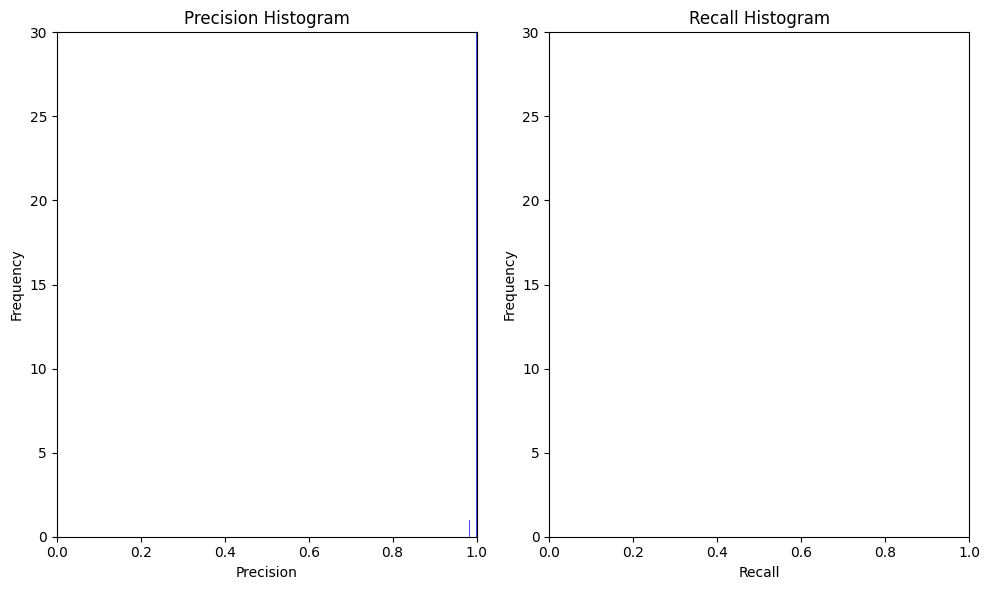

In [7]:
TP = []
FP = []
TN = []
FN = []
for bnet in all_data:
    if len(all_data[bnet]["paths_reachability"]) == 0:
        continue
    TP.append(all_data[bnet]["paths_reachability"]["sd_all"][0])
    FP.append(all_data[bnet]["paths_reachability"]["sd_all"][1])
    TN.append(all_data[bnet]["paths_reachability"]["sd_all"][2])
    FN.append(all_data[bnet]["paths_reachability"]["sd_all"][3])

print(np.mean(TP), np.mean(FP), np.mean(TN), np.mean(FN))

plot_precision_and_recall(TP, FP, TN, FN)

126.68131868131869 0.07692307692307693 0.0 0.0


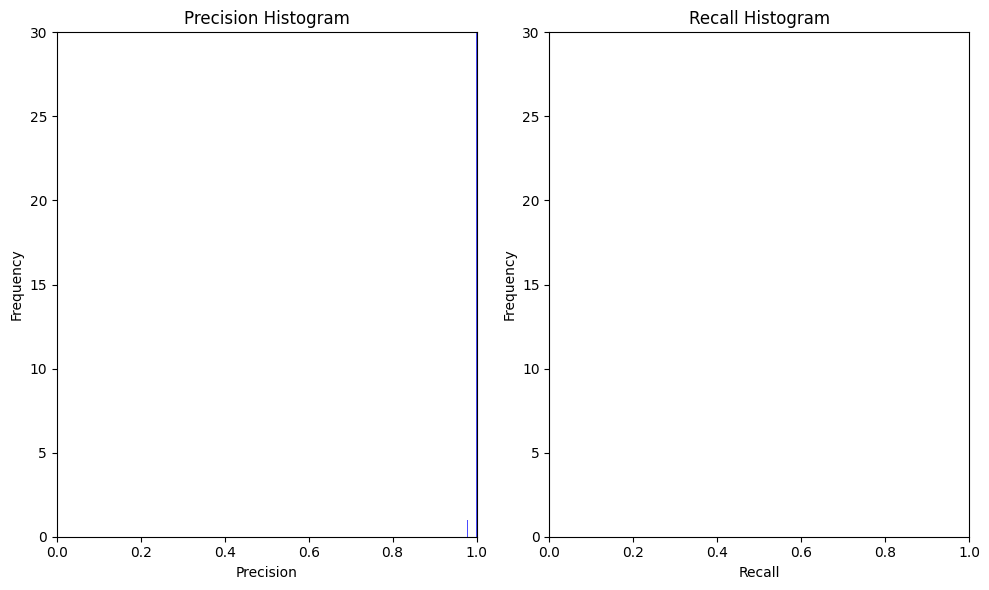

In [8]:
TP = []
FP = []
TN = []
FN = []
for bnet in all_data:
    if len(all_data[bnet]["paths_reachability"]) == 0:
        continue
    TP.append(all_data[bnet]["paths_reachability"]["sd_non_edges"][0])
    FP.append(all_data[bnet]["paths_reachability"]["sd_non_edges"][1])
    TN.append(all_data[bnet]["paths_reachability"]["sd_non_edges"][2])
    FN.append(all_data[bnet]["paths_reachability"]["sd_non_edges"][3])

print(np.mean(TP), np.mean(FP), np.mean(TN), np.mean(FN))

plot_precision_and_recall(TP, FP, TN, FN)